In [ ]:
#importing the required libraries
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#installing keras
!pip install -q keras
import keras

In [ ]:
#mounting our google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading the dataset
data = pd.read_csv('/content/archive-3/data.csv')
data.head()

,Unnamed: 0,image,classes
0,0,image/0.jpeg,unknown
1,1,image/1.jpeg,head_lamp
2,2,image/2.jpeg,door_scratch
3,3,image/3.jpeg,head_lamp
4,4,image/4.jpeg,unknown


In [ ]:
#directing the images of the dataset to the corresponding google drive path
path = '/content/archive-3/'
def edit_path_img(x):
    return path + x

In [ ]:
#correct paths to the images of damaged vehicles
data["image"] = data["image"].apply(edit_path_img)
data.head()

,Unnamed: 0,image,classes
0,0,/content/archive-3/image/0.jpeg,unknown
1,1,/content/archive-3/image/1.jpeg,head_lamp
2,2,/content/archive-3/image/2.jpeg,door_scratch
3,3,/content/archive-3/image/3.jpeg,head_lamp
4,4,/content/archive-3/image/4.jpeg,unknown


In [ ]:
print('Dataframe number of records = '+str(data.shape[0]))
print('Dataframe number of variables (including the class) = '+str(data.shape[1]))

Dataframe number of records = 1594
Dataframe number of variables (including the class) = 3


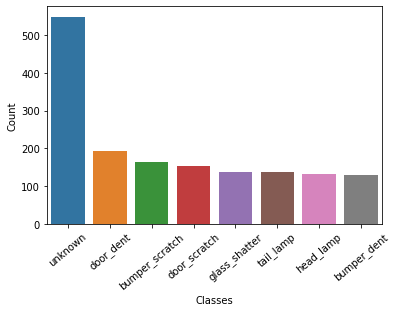

In [ ]:
#exploratory data analysis on the frequency count of various damage causes
counts = data['classes'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=40);

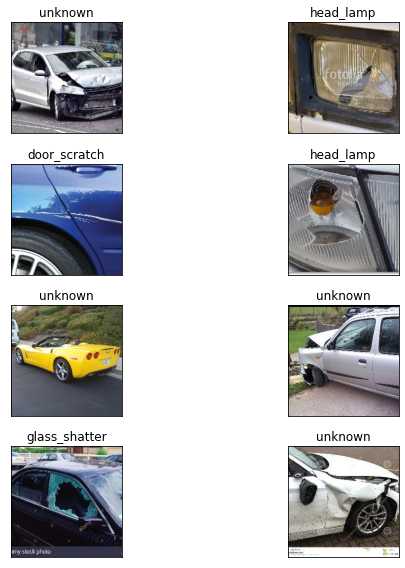

In [ ]:
#to observe a few samples from the dataset
datafig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.image[i]))
    ax.set_title(data.classes[i])
plt.tight_layout()
plt.show()

In [ ]:
#splitting the datset into training and testing counterparts
train_df, test_df = train_test_split(data, test_size=0.3)

In [ ]:
#preprocessing the images using preprocess_input for mobilenetv2 as imported previously
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
#generating validation splits for training epochs of the mobile net architecture on our dataset
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1115 validated image filenames belonging to 8 classes.
Found 1115 validated image filenames belonging to 8 classes.
Found 479 validated image filenames belonging to 8 classes.


In [ ]:
#initializing the pretrained model of MobileNetV2 
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
#initializing our model in form if keras Model as imported previously
inputs = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
#compiling our model using the adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#creating an early stopping condition on the basis of the validation accuracy achieved to prevent overfitting of the model
my_callbacks  = [EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')]

In [ ]:
#output of the history of the training of our model over max 50 epochs, but subject to the early stopping condition
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

Epoch 1/50
35/35 [==============================] - 67s 2s/step - loss: 1.3058 - accuracy: 0.5552 - val_loss: 0.6855 - val_accuracy: 0.7749
Epoch 2/50
35/35 [==============================] - 63s 2s/step - loss: 0.6059 - accuracy: 0.8000 - val_loss: 0.3909 - val_accuracy: 0.8942
Epoch 3/50
35/35 [==============================] - 63s 2s/step - loss: 0.3961 - accuracy: 0.8798 - val_loss: 0.2718 - val_accuracy: 0.9318
Epoch 4/50
35/35 [==============================] - 64s 2s/step - loss: 0.2642 - accuracy: 0.9238 - val_loss: 0.1790 - val_accuracy: 0.9570
Epoch 5/50
35/35 [==============================] - 64s 2s/step - loss: 0.1658 - accuracy: 0.9561 - val_loss: 0.1117 - val_accuracy: 0.9785
Epoch 6/50
35/35 [==============================] - 64s 2s/step - loss: 0.0965 - accuracy: 0.9821 - val_loss: 0.0518 - val_accuracy: 0.9955
Epoch 7/50
35/35 [==============================] - 64s 2s/step - loss: 0.0543 - accuracy: 0.9973 - val_loss: 0.0396 - val_accuracy: 0.9982
Epoch 8/50
35/35 [==

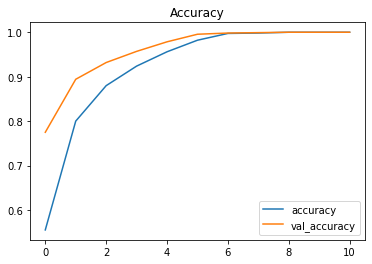

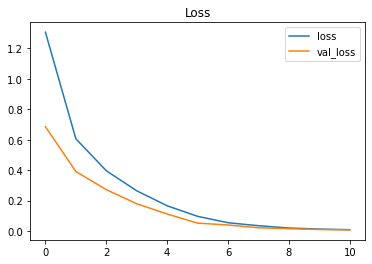

In [ ]:
#plotting the training and validation accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

#plotting the training and validation loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
#evaluating the testing loss and accuracy
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.84706
Test Accuracy: 78.91%


In [ ]:
#using our model to predict the labels for images in the testing datset
y_pred = model.predict(test_gen )
y_pred = np.argmax(y_pred,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in y_pred]

In [ ]:
#classification report on the basis of individual classes as well as the overall performance
y_test = list(test_df.classes)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

   bumper_dent       0.68      0.65      0.67        46
bumper_scratch       0.82      0.96      0.88        55
     door_dent       0.65      0.72      0.68        54
  door_scratch       0.64      0.64      0.64        39
 glass_shatter       0.87      0.87      0.87        38
     head_lamp       0.73      0.67      0.70        36
     tail_lamp       0.80      0.62      0.70        45
       unknown       0.88      0.88      0.88       166

      accuracy                           0.79       479
     macro avg       0.76      0.75      0.75       479
  weighted avg       0.79      0.79      0.79       479



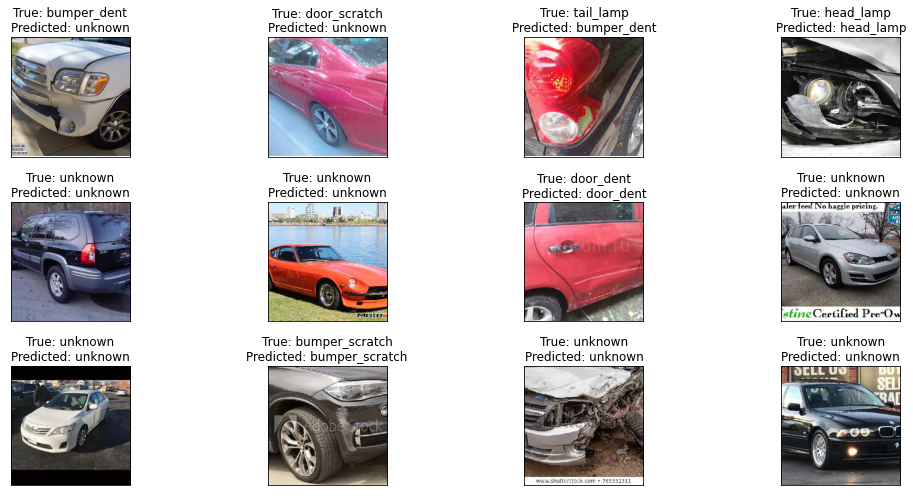

In [ ]:
#visualizing the predicted vs. actual labels given to our testing samples
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.classes.iloc[i]}\nPredicted: {y_pred[i]}")
plt.tight_layout()
plt.show()